<a href="https://colab.research.google.com/github/rafaelventura204/3D_Segmentation/blob/main/3D_Segmentation_Active_Contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Definizione immagine Sfera prolata

In [77]:
# Definizione della classe per creare una sfera prolata
class ProlateSpheroid:
    def __init__(self, size=128, a=48, c=64, shell_thickness=2):
        self.size = size
        self.equatorial_radius = a
        self.polar_radius = c
        self.shell_thickness = shell_thickness
        self.matrix = self.create_spheroid()

    def create_spheroid(self):
        volume = np.full((self.size, self.size, self.size), 255)  # Initialize all voxels to 255 (outside)
        center = np.array([self.size // 2, self.size // 2, self.size // 2])

        for x in range(self.size):
            for y in range(self.size):
                for z in range(self.size):
                    distance_from_center = ((x - center[0])**2 + (y - center[1])**2) / self.equatorial_radius**2 \
                                           + (z - center[2])**2 / self.polar_radius**2
                    # Inside the spheroid
                    if distance_from_center < 1:
                        volume[x, y, z] = 127  # Set voxels inside the spheroid to 127 (inside)
                    # Within the shell thickness
                    elif 1 <= distance_from_center < 1 + (self.shell_thickness/self.size)**2:
                        volume[x, y, z] = 0  # Set voxels within the shell thickness to 0 (shell)
        return volume

# Create a prolate spheroid with a thicker shell
spheroid = ProlateSpheroid(shell_thickness=90)

# Downsampling per la visualizzazione
downsampling_factor = 4
downsampled_matrix = spheroid.matrix[::downsampling_factor, ::downsampling_factor, ::downsampling_factor]

# Estrazione delle coordinate
x, y, z = np.where(downsampled_matrix != 255) #se commentata fa vedere la parte esterna

# Funzione per mappare i valori ai colori
def color_mapper(value):
    if value == 0:
        return 'black'  # shell
    elif value == 127:
        return 'blue'   # inside spheroid
    else:
        return 'yellow'  # outside spheroid

# Applicazione della funzione di mapping
colors = np.vectorize(color_mapper)(downsampled_matrix[x, y, z])

# Creazione del grafico 3D
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=colors,  # colori dei punti
        opacity=0.8
    )
)])

# Aggiornamento del layout per una migliore visualizzazione
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis (Polar Axis)'),
        aspectratio=dict(x=1, y=1, z=1.5)  # Rapporto d'aspetto per enfatizzare la forma prolata
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Visualizzazione della figura
fig.show()


Sotto matrice della matrice originale!

In [78]:
# Calcolo le coordinate centrali della matrice 3D
center = spheroid.size // 2
half_subportion = 32 // 2  # Metà della dimensione della sotto-porzione

# Prendo la sotto-porzione centrale della matrice 3D
subportion_matrix = spheroid.matrix[center-half_subportion:center+half_subportion,
                                    center-half_subportion:center+half_subportion,
                                    center-half_subportion:center+half_subportion]

# Verifico la dimensione della sotto-porzione per assicurarmi che sia corretta
subportion_matrix.shape

(32, 32, 32)

Estrazione di slice con spaziatura di 2mm dalla sotto matrice

In [79]:
# Correggiamo la funzione per estrarre le slice con una spaziatura di 2mm (equivalenti a 2 voxel se 1 voxel = 1 mm)
def extract_spaced_slices_correctly(matrix, spacing_mm, mm_per_voxel=1):
    """
    Estrae le slice distanziate da una specifica quantità in millimetri.

    :param matrix: Matrice 3D dalla quale estrarre le slice.
    :param spacing_mm: Spaziatura in millimetri tra le slice.
    :param mm_per_voxel: Quanti millimetri rappresenta ogni voxel (assumendo voxel cubici).
    :return: Un dizionario contenente le slice estratte lungo ogni asse.
    """
    # Calcoliamo quanti voxel corrispondono alla spaziatura in millimetri
    # Usiamo divisione normale per calcolare il numero di voxel per la spaziatura data
    spacing_voxels = spacing_mm / mm_per_voxel

    # Calcoliamo l'indice per iniziare a estrarre le slice
    start_index = spacing_voxels

    # Determiniamo gli indici per estrarre le slice con la spaziatura data
    # Si parte dall'indice start_index e si procede con passi di spacing_voxels + 1 per includere ogni spacing_voxels-esimo voxel
    indices = np.arange(start_index, matrix.shape[0], spacing_voxels).astype(int)

    # Estraiamo le slice distanziate
    slices_x = matrix[indices, :, :]
    slices_y = matrix[:, indices, :]
    slices_z = matrix[:, :, indices]

    return {
        'x': slices_x,
        'y': slices_y,
        'z': slices_z
    }

# Applichiamo la funzione corretta alla sotto-porzione centrata
spaced_slices_correct = extract_spaced_slices_correctly(subportion_matrix, spacing_mm=2, mm_per_voxel=1)

# Verifichiamo la dimensione delle slice estratte
slices_shapes_correct = {axis: spaced_slices_correct[axis].shape for axis in 'xyz'}
slices_shapes_correct


{'x': (15, 32, 32), 'y': (32, 15, 32), 'z': (32, 32, 15)}

PARTE PRIMA: Segmentazione 2D U-net

In [80]:
def generate_ground_truth_masks(slices_dict):
    masks_dict = {}
    for axis, slices in slices_dict.items():
        masks = (slices == 127).astype(np.float32)  # 1 per i pixel interni, 0 per il guscio e l'esterno
        masks_dict[axis] = masks
    return masks_dict

# Generiamo le maschere di ground truth
ground_truth_masks = generate_ground_truth_masks(spaced_slices_correct)

In [81]:
def unet(input_size=(32, 32, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=conv8)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[Precision(name='precision')])


    return model

# Creazione del modello U-Net
model = unet()

Preparazione dati allenamento e addestramento modello

Pre-elaborazione delle Slice e delle Maschere di Ground Truth:

In [82]:
# Assumiamo che spaced_slices_correct sia il tuo dizionario con le slice e ground_truth_masks le tue maschere

# Preparazione delle immagini di input e delle maschere di ground truth
# Convertiamo i dizionari in liste e quindi in array numpy
X = np.array(spaced_slices_correct['x'])  # Utilizza 'y' o 'z' se preferisci quelle slice
y = np.array(ground_truth_masks['x'])  # Lo stesso vale per 'y' o 'z'

# Normalizzazione dei dati di input
X_norm = X / 255.0
y_norm = y  # Le maschere sono già 0 o 1, quindi non necessitano di normalizzazione

# Ridimensionamento aggiungendo una dimensione canale per Keras
X_norm = np.expand_dims(X_norm, axis=-1)
y_norm = np.expand_dims(y_norm, axis=-1)

# Divisione in set di allenamento e validazione
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)


Configurazione dei Callback:



In [83]:
# Configurazione dei callback per salvare il miglior modello e fermare l'addestramento se non ci sono miglioramenti
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)


Addestramento del Modello:



In [84]:
# Costruzione del modello U-Net (utilizza la funzione unet fornita in precedenza)
model = unet(input_size=(32, 32, 1))

# Addestramento del modello
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.6772 - precision: 1.0000 - val_loss: 0.6739 - val_precision: 1.0000
Epoch 2/50
1/1 [==============================] - 0s 252ms/step - loss: 0.6739 - precision: 1.0000 - val_loss: 0.6710 - val_precision: 1.0000
Epoch 3/50
1/1 [==============================] - 0s 253ms/step - loss: 0.6710 - precision: 1.0000 - val_loss: 0.6682 - val_precision: 1.0000
Epoch 4/50
1/1 [==============================] - 0s 256ms/step - loss: 0.6682 - precision: 1.0000 - val_loss: 0.6653 - val_precision: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 235ms/step - loss: 0.6653 - precision: 1.0000 - val_loss: 0.6621 - val_precision: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 258ms/step - loss: 0.6621 - precision: 1.0000 - val_loss: 0.6585 - val_precision: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 257ms/step - loss: 0.6585 - precision: 1.0000 - val_loss: 0.6545 - val_precision: 1.0000
Epoch 8/5

Valutazione del Modello:

In [85]:
# Valutazione del modello sui dati di validazione
model.evaluate(X_val, y_val)


1/1 [==============================] - 0s 38ms/step - loss: 5.4950e-04 - precision: 1.0000


[0.000549495336599648, 1.0]

In [86]:
# Valutazione del modello sui dati di validazione per ottenere la precisione
val_loss, val_precision = model.evaluate(X_val, y_val)
print(f"Validation precision: {val_precision}")


1/1 [==============================] - 0s 37ms/step - loss: 5.4950e-04 - precision: 1.0000
Validation precision: 1.0


Visualizzazione delle Curve di Addestramento:



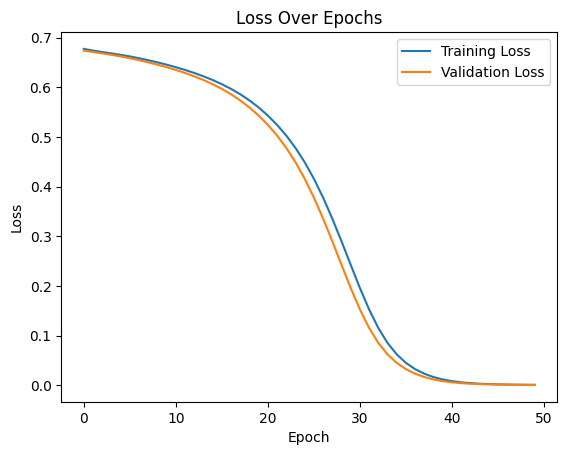

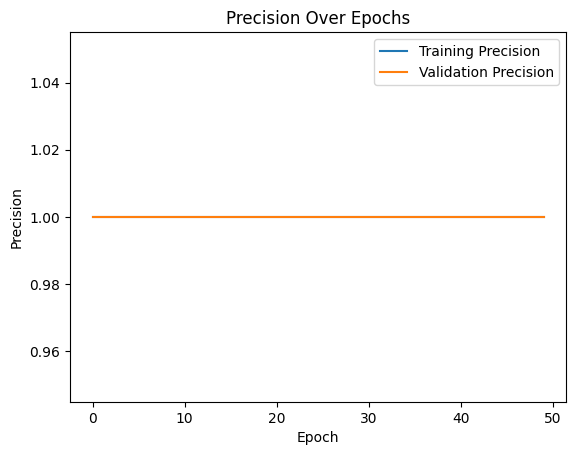

In [89]:

# Plot delle curve di addestramento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot delle curve di addestramento per la precisione
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.legend()
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()




In [91]:

# Calcola le predizioni sul set di validazione
y_pred = model.predict(X_val)
y_pred_thresholded = y_pred > 0.5

# Calcolare le metriche manualmente o utilizzare quelle di Keras
precision = Precision()
recall = Recall()
accuracy = Accuracy()

precision.update_state(y_val, y_pred_thresholded)
recall.update_state(y_val, y_pred_thresholded)
accuracy.update_state(y_val, y_pred_thresholded)

print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')

# Calcolo dell'F1-score
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy() + 1e-7)
print(f'F1-score: {f1_score}')

# Calcolo dell'Intersection over Union (IoU)
# Calcola le predizioni binarie sogliando il risultato
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcola le maschere binarie di ground truth
y_val_binary = (y_val > 0.5).astype(int)

# Calcolo dell'Intersection over Union (IoU)
intersection = np.logical_and(y_val_binary, y_pred_binary).sum()
union = np.logical_or(y_val_binary, y_pred_binary).sum()
iou = intersection / (union + 1e-7)

print(f'IoU (Intersection over Union): {iou}')



1/1 [==============================] - 0s 89ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0
F1-score: 0.9999999500000026
IoU (Intersection over Union): 0.9999999999674479
